In [18]:
# import torch, os

# outdir = "/home/uit2023/LuuTru/Thuchd/cs431/IP-Adapter-Update/outputs_MLP/cc3m_v2"
# ckpt = {
#     "image_proj": torch.load(os.path.join(outdir, "image_proj_step250000.bin"), map_location="cpu"),
#     "ip_adapter": torch.load(os.path.join(outdir, "ip_adapter_step250000.bin"),  map_location="cpu"),
# }

# save_dir = "/home/uit2023/LuuTru/Thuchd/cs431/IP-Adapter-Update/models"
# os.makedirs(save_dir, exist_ok=True)

# save_path = os.path.join(save_dir, "ip-adapter_step250000.bin")  # <-- phải là file, không phải thư mục
# torch.save(ckpt, save_path)
# print("Wrote:", save_path)

# # kiểm tra
# sd = torch.load(save_path, map_location="cpu")
# print("keys:", list(sd.keys()))  # phải thấy ['image_proj', 'ip_adapter']


In [19]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapterMLP

In [20]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(3)  # chọn GPU 0


In [21]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "openai/clip-vit-base-patch32"
ip_ckpt = "/home/uit2023/LuuTru/Thuchd/cs431/IPAdapter/modelMLP/ip-adapter_step250000.bin"
device = "cuda"

In [22]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [23]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  8.51it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


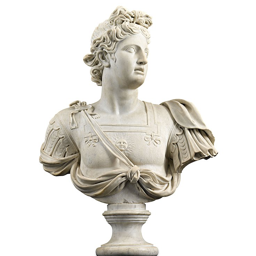

In [24]:
# read image prompt
image = Image.open("assets/images/statue.png")
image.resize((256, 256))

In [25]:
# load ip-adapter
ip_model = IPAdapterMLP(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


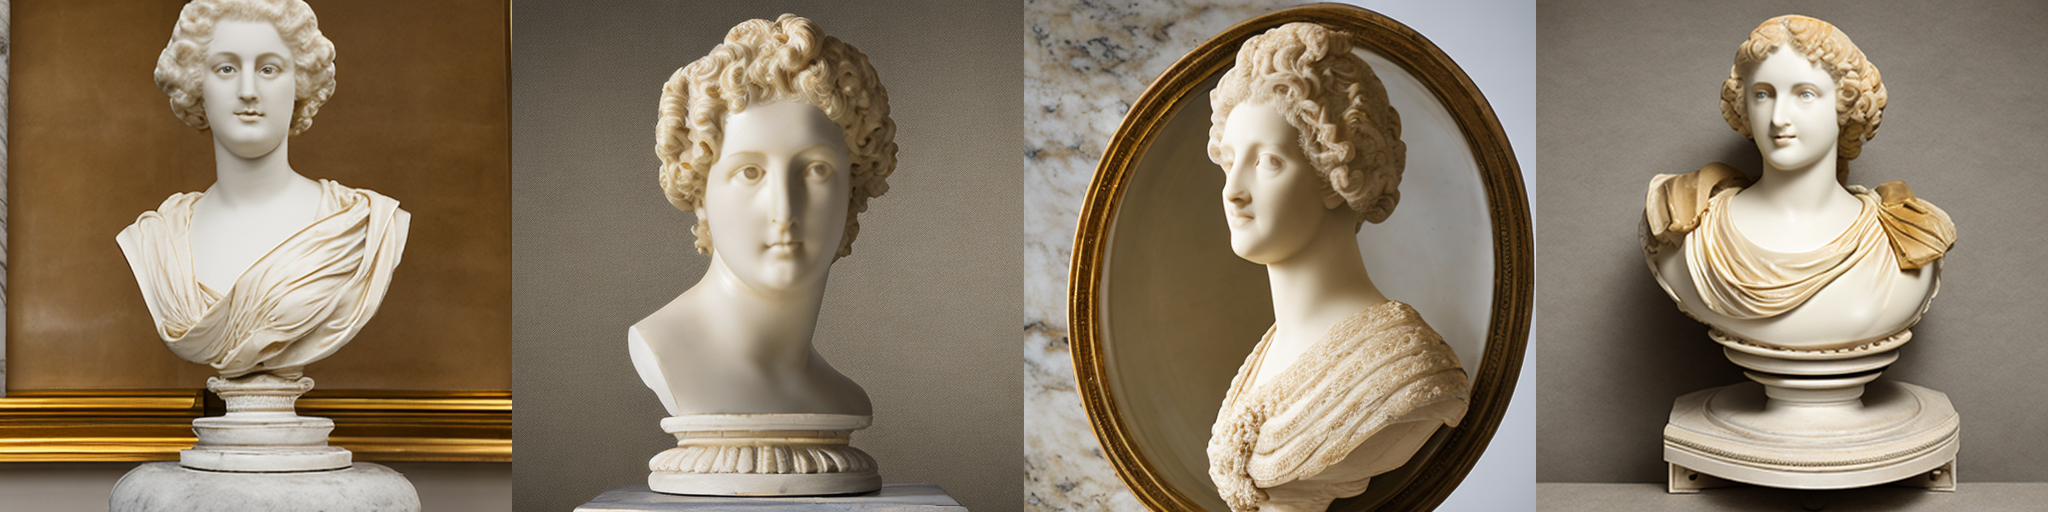

In [26]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

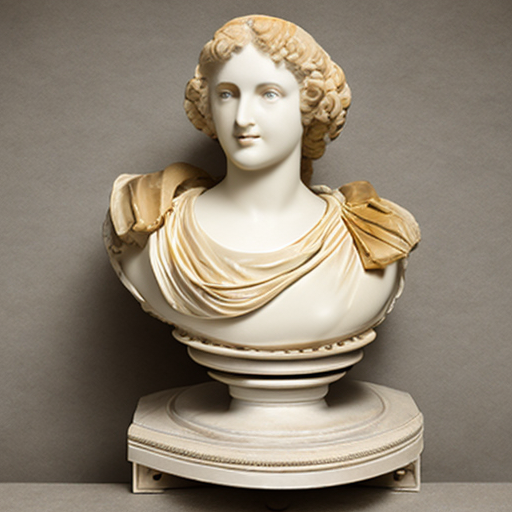

In [27]:
images[3]

# MultiModal

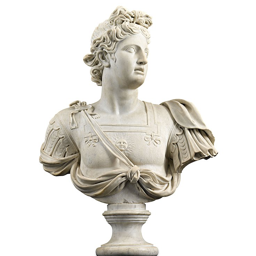

In [28]:
# read image prompt
image = Image.open("assets/images/statue.png")
image.resize((256, 256))

In [29]:
#base_model_path = "runwayml/stable-diffusion-v1-5"
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "openai/clip-vit-base-patch32"
ip_ckpt = "/home/uit2023/LuuTru/Thuchd/cs431/IPAdapter/modelMLP/ip-adapter_step250000.bin"
device = "cuda"

In [30]:
# load SD pipeline
del pipe, ip_model
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:  20%|██        | 1/5 [00:00<00:00,  6.97it/s]

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.56it/s]


In [31]:
# load ip-adapter
ip_model = IPAdapterMLP(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


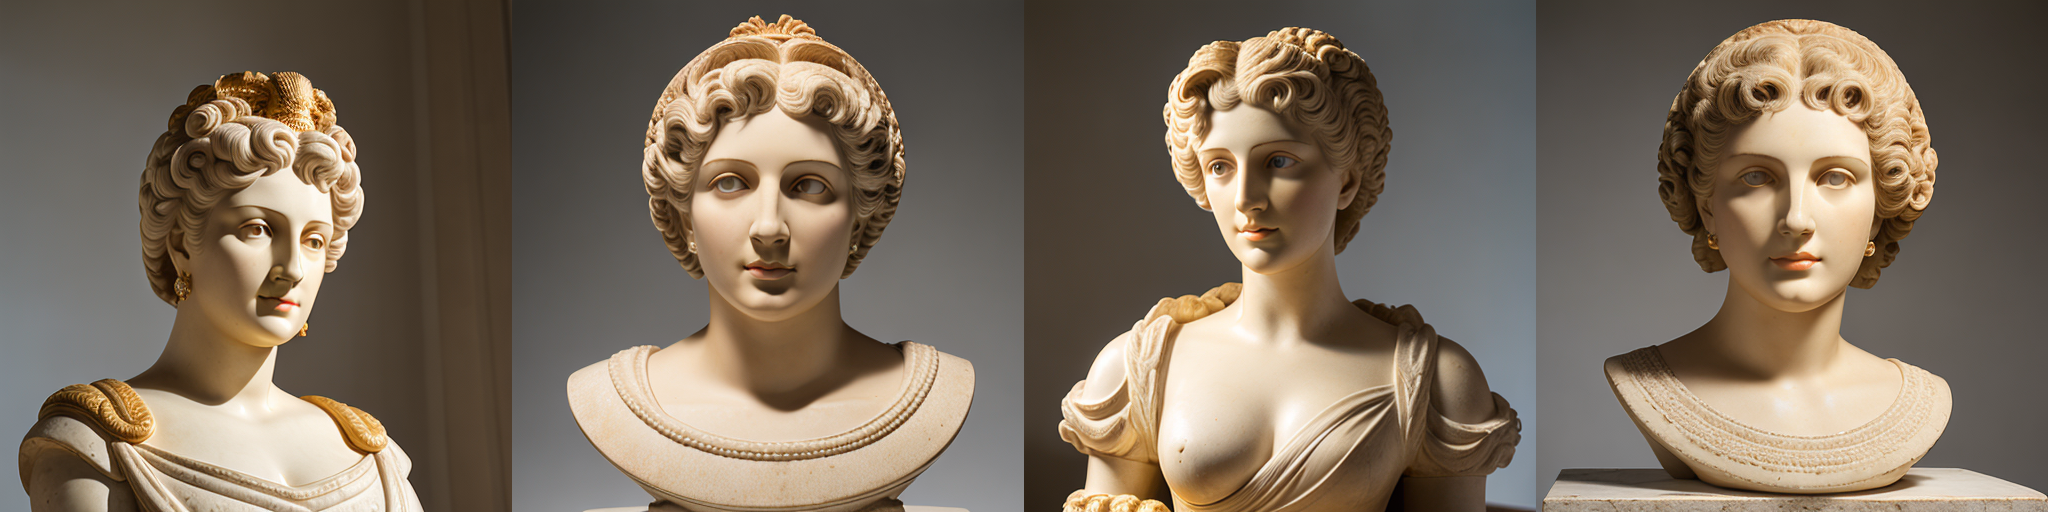

In [32]:
# generate image variations
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

  6%|▌         | 3/50 [00:00<00:10,  4.39it/s]

100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


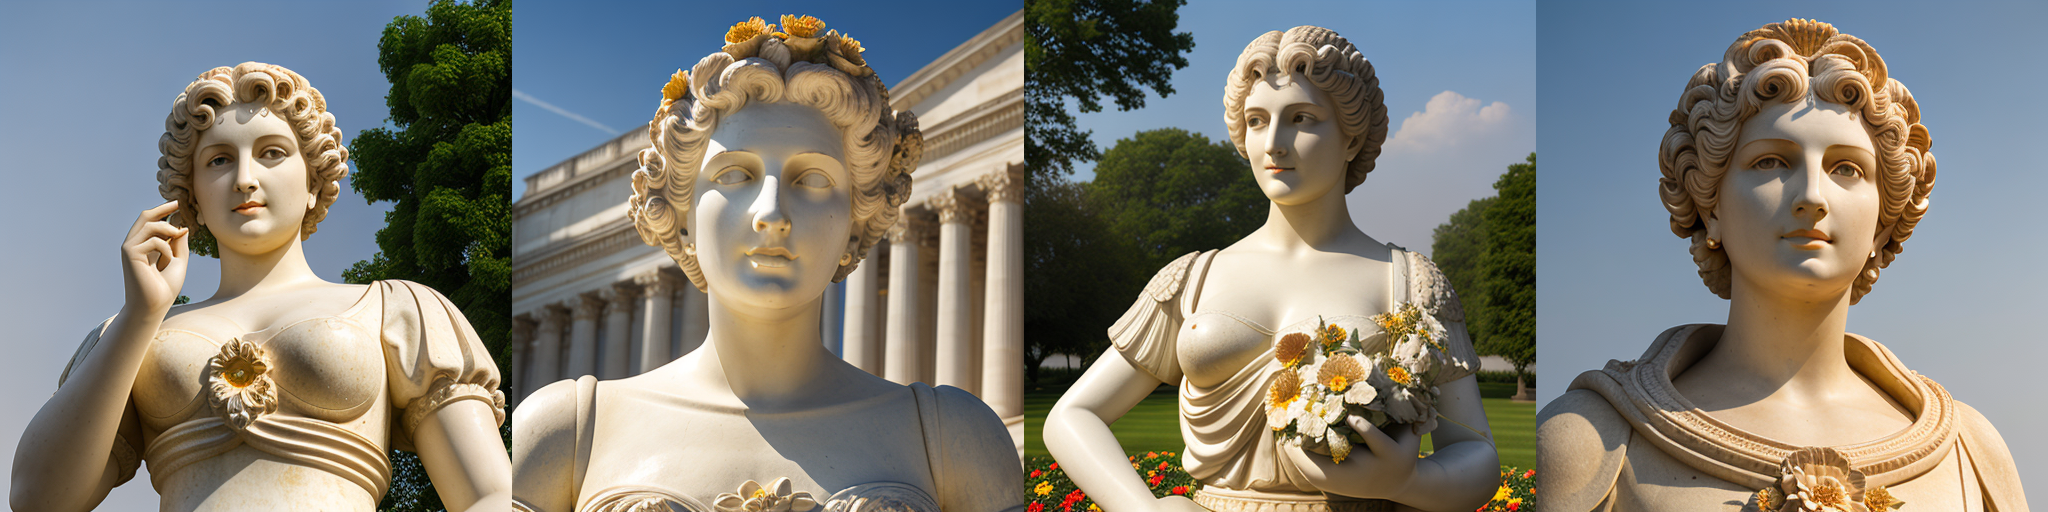

: 

In [ ]:
# multimodal prompts
images = ip_model.generate(pil_image=image, num_samples=4, num_inference_steps=50, seed=42,
        prompt="best quality, high quality, in a garden with flowers", scale=0.5)
grid = image_grid(images, 1, 4)